In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
# from  flame_classification.flame_classification import FCA
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import tensorflow as tf
import random
import sklearn.metrics as metrics

Using TensorFlow backend.


In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

In [3]:
call_backs = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               mode='min',patience=10),
             tf.keras.callbacks.ModelCheckpoint('max_accuracy_final1.h5',
                                                save_best_only=True,
                                                monitor='val_accuracy',
                                                mode='max')]

In [4]:
def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 5, activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 5, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        return model

    model = tf.keras.models.Sequential()
    model.add(Input(shape=(74, 74, 1)))
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [5]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 70, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 70, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 66, 66, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        1

### Open flame type

In [6]:
### flame type data set
with h5py.File('../flame_classification/data//y_flames_classification.h5',
               "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data_y = list(f[a_group_key])

Keys: <KeysViewHDF5 ['Y_data']>


In [7]:
data_y.pop(0)

0

#### Open Images

In [8]:
### image data set
with h5py.File('../flame_classification/data//x_flames_classification.h5', "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data_x = list(f[a_group_key])

Keys: <KeysViewHDF5 ['X_data']>


In [9]:
data_x.pop(0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
# plt.imshow(data_x[-1])

#### Convert images to gray scale

In [11]:
x_data_gray = [((arr - arr.min()) * (1 / (arr.max() - arr.min())))
               for arr in data_x]

In [12]:
x_data_gray[1].shape

(74, 74)

#### Distribution of flame types

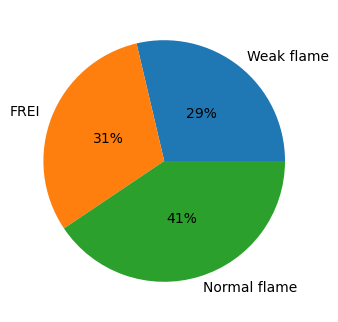

In [13]:
labels = ['Weak flame', 'FREI', 'Normal flame']
occurance_perc = [
    sum([1 for i in data_y if i == 0]) / len(data_y),
    sum([1 for i in data_y if i == 1]) / len(data_y),
    sum([1 for i in data_y if i == 2]) / len(data_y)
]
plt.figure(figsize=(4, 4), dpi=100)
plt.pie(
    occurance_perc,
    labels=labels,
    autopct='%1.0f%%',
    pctdistance=0.5,
    labeldistance=1.1,
);

#### Shuffling the dataset

In [14]:
c = list(zip(x_data_gray, data_y))

random.shuffle(c)

(x_data_gray, data_y) = zip(*c)

data_y = np.asarray(data_y).astype('uint8')

In [15]:
x_data_gray = np.asarray(x_data_gray)

In [16]:
x_data_gray = x_data_gray.reshape(5910, 74, 74,1)

In [17]:
class_names = ['Weak flame', 'FREI', 'Normal Flame']

In [18]:
data_y = tf.keras.utils.to_categorical(data_y)

In [19]:
mm = int(len(x_data_gray) * 0.8)
nn = int(len(x_data_gray) * 0.9)

In [20]:
X_train = x_data_gray[:mm]
X_test = x_data_gray[mm:nn]
X_valid = x_data_gray[nn:]
y_train = data_y[:mm]
y_test = data_y[mm:nn]
y_valid = data_y[nn:]

In [21]:
numb = 42
tf.random.set_seed(numb)

In [22]:
model_history = model.fit(X_train,
                          y_train,
                          epochs=100,
                          validation_data=(X_valid, y_valid),
                          callbacks=call_backs,
                          use_multiprocessing = True)

Train on 4728 samples, validate on 591 samples
Epoch 1/100
4728/4728 [==============================] - 97s 20ms/sample - loss: 0.6915 - accuracy: 0.7974 - val_loss: 2.4473 - val_accuracy: 0.4349
Epoch 2/100
4728/4728 [==============================] - 94s 20ms/sample - loss: 0.2063 - accuracy: 0.9264 - val_loss: 1.4703 - val_accuracy: 0.5838
Epoch 3/100
4728/4728 [==============================] - 93s 20ms/sample - loss: 0.2093 - accuracy: 0.9382 - val_loss: 1.2465 - val_accuracy: 0.6142
Epoch 4/100
4728/4728 [==============================] - 94s 20ms/sample - loss: 0.1223 - accuracy: 0.9636 - val_loss: 0.2493 - val_accuracy: 0.9103
Epoch 5/100
4728/4728 [==============================] - 92s 20ms/sample - loss: 0.1072 - accuracy: 0.9657 - val_loss: 0.0914 - val_accuracy: 0.9763
Epoch 6/100
4728/4728 [==============================] - 92s 20ms/sample - loss: 0.0951 - accuracy: 0.9691 - val_loss: 0.0762 - val_accuracy: 0.9729
Epoch 7/100
4728/4728 [==============================] - 93

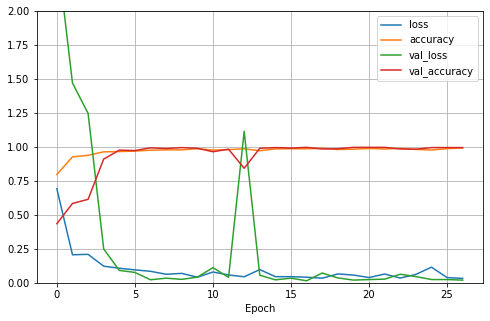

In [34]:
df = pd.DataFrame(model_history.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.xlabel('Epoch')
plt.show()

In [24]:
y_pred = model.predict_classes(X_test)

In [25]:
y_pred=tf.keras.utils.to_categorical(y_pred)

In [26]:
y_pred

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [27]:
y_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [28]:
sum([1 for i in range(len(y_test)) if sum(abs(y_pred - y_test)[i]) != 0])

4

In [29]:
perc = (len(y_test) -sum([1 for i in range(len(y_test)) if sum(abs(y_pred - y_test)[i]) != 0]))/len(y_test)*100

In [30]:
print('{}% is the accuracy for the test dataset'.format(round(perc, 3)))

99.323% is the accuracy for the test dataset


In [31]:
len(y_test)

591

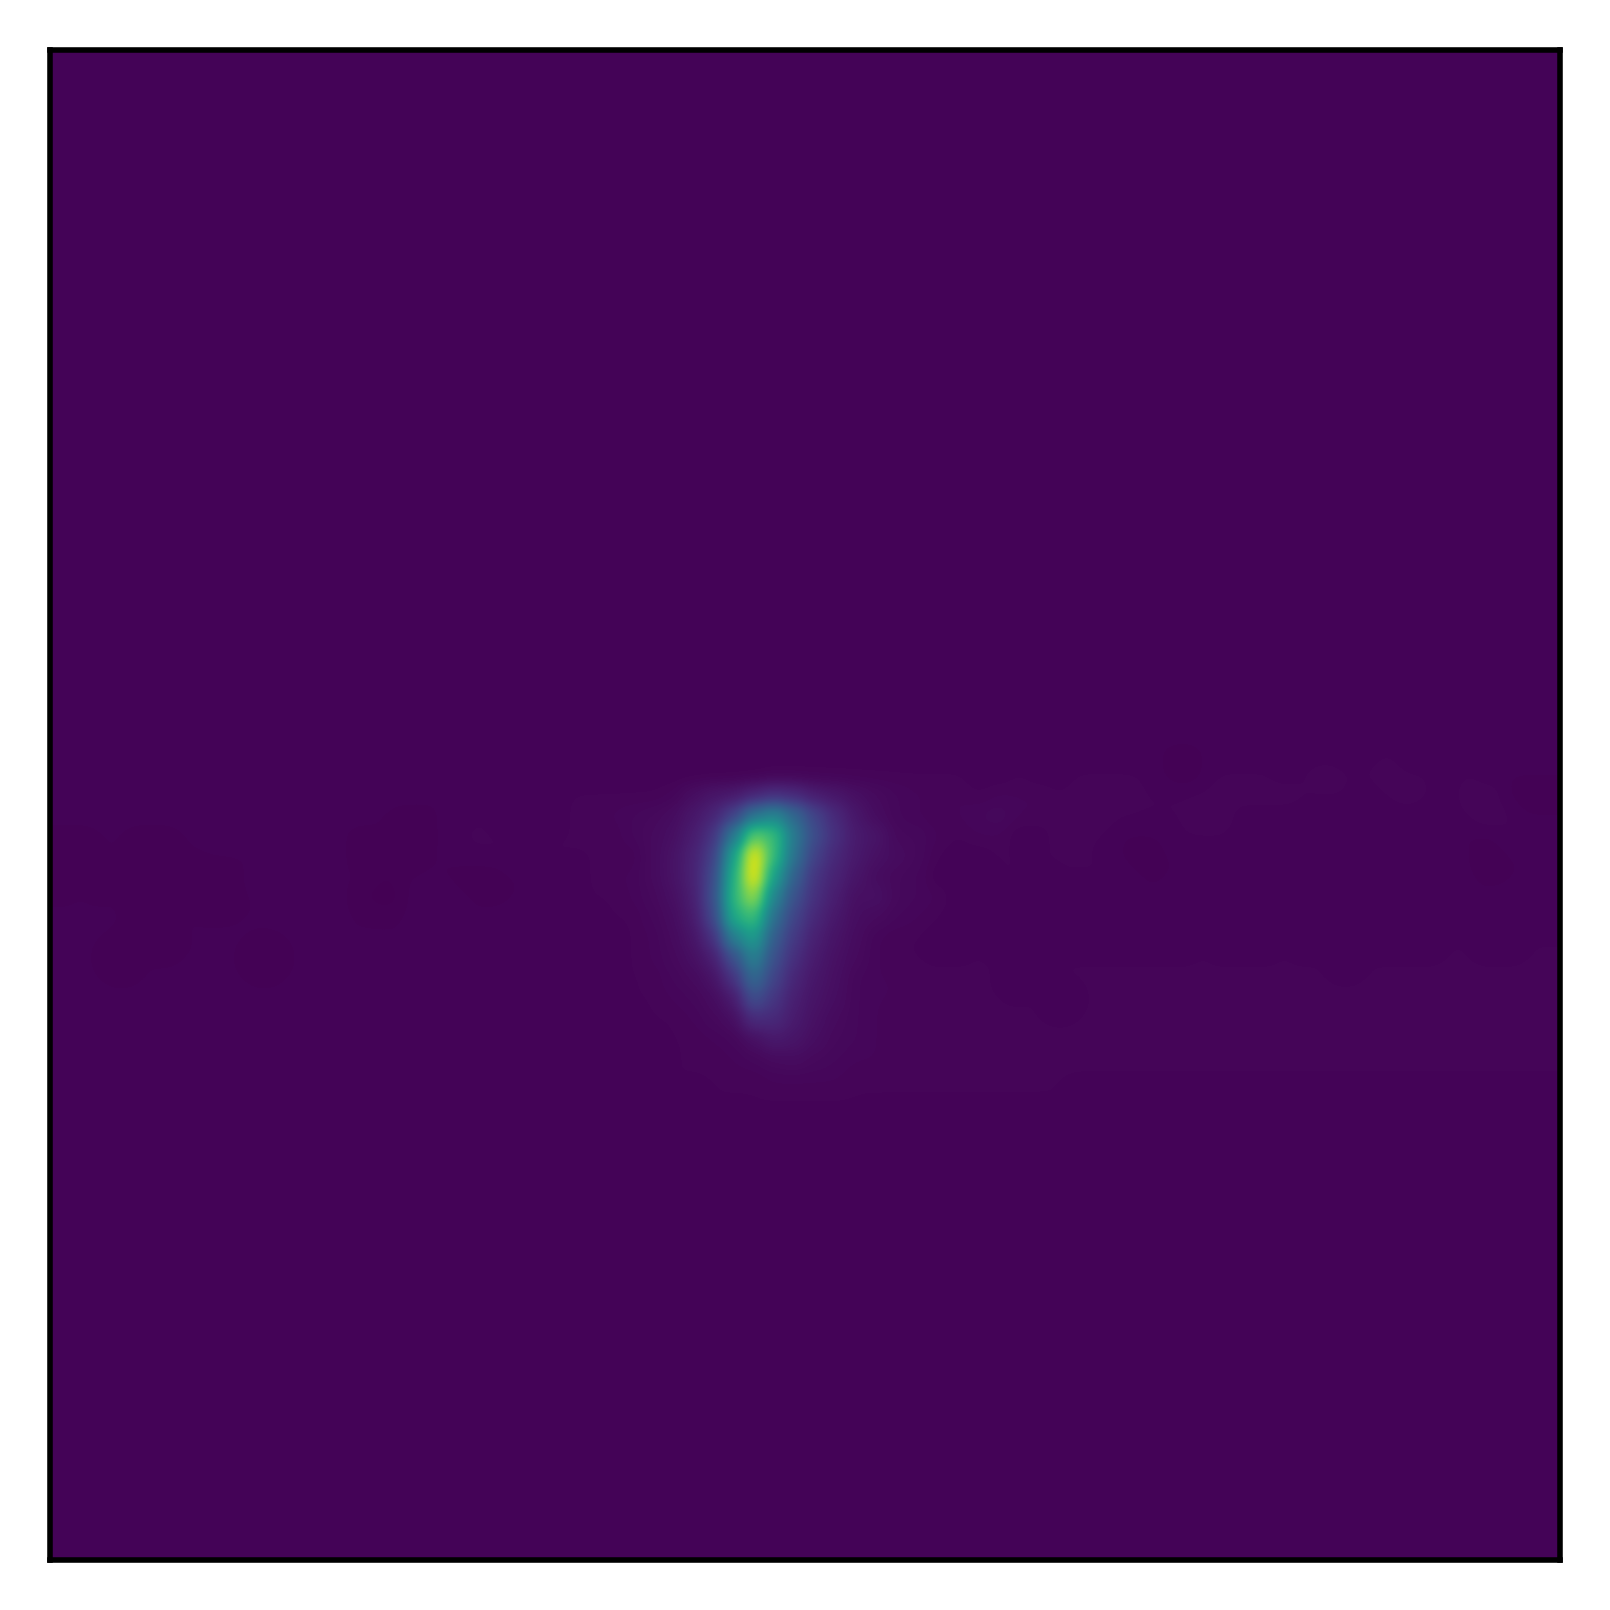

In [32]:
plt.figure(dpi=500)
plt.imshow(X_test[0].reshape(74,74),interpolation='gaussian');
plt.tick_params(left=False, bottom = False,labelleft=False,labelbottom=False);